# Autoencoder para colorear imagenes JDM


In [87]:
import numpy as np 
import matplotlib.pyplot as plt 
import os

from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import plot_model

# Función para convertir una imagen a color en tonos de gris

In [3]:
def rgb2gray(image):
    return np.dot(image[...,:3], [0.299,0.587,0.114]) # [0.299,0.587,0.114] constantes para transformar a BN
      

# Lee datos

In [4]:
(x_train, _), (x_test,_) = cifar100.load_data()
print   (x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Crear imagenes a escala de grises 

In [7]:
x_train_gray = x_train[..., :3]@[0.299, 0.587, 0.114]
x_test_gray = x_test[..., :3]@[0.299, 0.587, 0.114]
 
# Remodelar el modelo
x_train_gray = np.expand_dims(x_train_gray, axis=3)
x_test_gray = np.expand_dims(x_test_gray, axis=3)

print(x_train_gray.shape)
print(x_test_gray.shape)


(50000, 32, 32, 1)
(10000, 32, 32, 1)


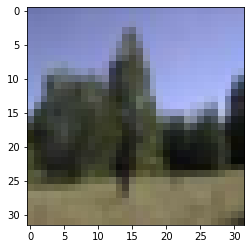

In [27]:
plt.imshow(x_train[110])
plt.show()

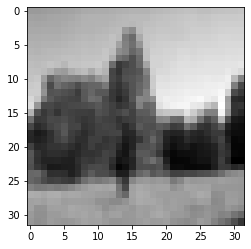

In [28]:
plt.imshow(x_train_gray[110], cmap='gray')
plt.show()

# Normaliza datos

In [22]:
x_train = x_train.astype('float32')/255. 
x_test = x_test.astype('float32')/255. 

x_train_gray = x_train_gray.astype('float32')/255. 
x_test_gray = x_test_gray.astype('float32')/255. 


# Parametros de configuración 

In [32]:
# Van a entrar x_train.shape[1] filas, x_train.shape[2] columnas y x_train.shape[3] canales de color
rows = x_train.shape[1]
cols = x_train.shape[2]
channels = x_train.shape[3]

input_shape = (rows, cols, 1)
batch_size = 256
kernel_size = 3
latent_dim = 256
layer_filters = [64,128,256]


# Encoder

In [38]:
inputs = Input(shape = input_shape)
x = inputs 
for filters in layer_filters:
    x = Conv2D(filters= filters,
               kernel_size = kernel_size,
               strides=2,
               activation= 'relu',
               padding='same')(x)

# Guardar la forma del decoder
shape = x.shape.as_list()
#shape = shape[1:]

x = Flatten()(x)
latent = Dense(latent_dim, name = 'Latent_Vector')(x)
encoder_colorizing = Model(inputs, latent, name = 'Encoder_Colorizing')

# Summary encoder_colorizing model

In [39]:
encoder_colorizing.summary()


Model: "Encoder_Colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
Latent_Vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
______________________________________

# Decoder

In [51]:
print(shape[1])
print(shape[2])
print(shape[3])
print(shape[1]*shape[2]*shape[3])
(shape[1], shape[2], shape[3])

4
4
256
4096


(4, 4, 256)

In [61]:
print(layer_filters)
print(layer_filters[::-1])

[64, 128, 256]
[256, 128, 64]


In [77]:
latent_inputs = Input(shape = (latent_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# Deconvolucion 
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size = kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters= channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding= 'same',
                          name = 'decoder_output')(x)

                          
         
decoder_colorizing = Model(latent_inputs, outputs, name = 'decoder_colorizing')

# Sumary decoder_colorizing model

In [78]:
decoder_colorizing.summary()

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)  

# Autoencoder

In [79]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)),
                               name = 'autoencoder_colorizing')

In [80]:
autoencoder_colorizing.summary()

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
Encoder_Colorizing (Function (None, 256)               1418496   
_________________________________________________________________
decoder_colorizing (Function (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


# Callbacks

In [83]:
# preparar el directorio de guardado del modelo.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'Colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
# reducir la tasa de aprendizaje en sqrt (0.1) si la pérdida no mejora en 5 épocas
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0, patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# Guardar los pesos para usos futuros (p.ej. recargar parámetros sin entrenamiento)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Llamar cada epoch
callbacks = [lr_reducer, checkpoint]

# Compilar

In [84]:
autoencoder_colorizing.compile(loss='mse',
                               optimizer = 'adam',
                               metrics = ['mae'])
                               

# Entrena

In [85]:
epochs = 10

history = autoencoder_colorizing.fit(x_train_gray, x_train,
                                     validation_data=(x_test_gray, x_test),
                                     epochs=epochs,
                                     batch_size= batch_size,
                                     callbacks=callbacks)

Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.1365
Epoch 00001: val_loss improved from inf to 0.02014, saving model to c:\Users\juand\Documents\DIPLOMADO EN INTELIGENCIA ARTIFICIAL Y APRENDIZAJE PROFUNDO\videos clases\Clase28\saved_models\Colorized_ae_model.001.h5
196/196 [==============================] - 376s 2s/step - loss: 0.0322 - mae: 0.1365 - val_loss: 0.0201 - val_mae: 0.1048
Epoch 2/10
196/196 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.0961
Epoch 00002: val_loss improved from 0.02014 to 0.01617, saving model to c:\Users\juand\Documents\DIPLOMADO EN INTELIGENCIA ARTIFICIAL Y APRENDIZAJE PROFUNDO\videos clases\Clase28\saved_models\Colorized_ae_model.002.h5
196/196 [==============================] - 393s 2s/step - loss: 0.0173 - mae: 0.0961 - val_loss: 0.0162 - val_mae: 0.0924
Epoch 3/10
196/196 [==============================] - ETA: 0s - loss: 0.0151 - mae: 0.0885
Epoch 00003: val_loss improved from 0.01617 to 0.01

In [86]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plt(history.history['val_loss'])
plt.grid()
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'plt'

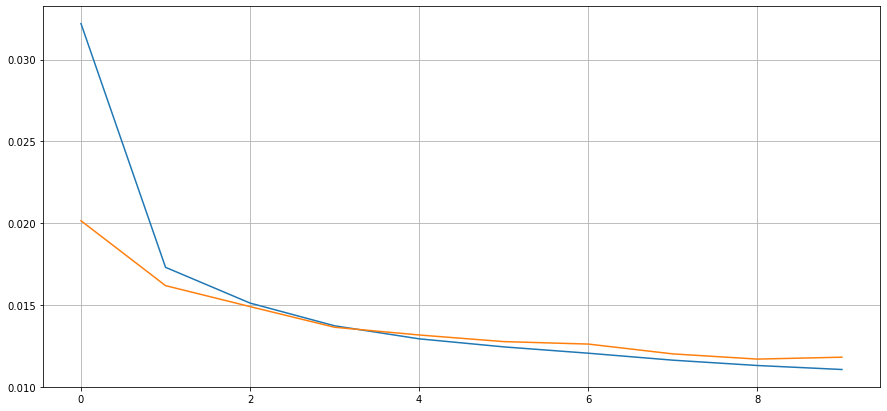

In [88]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

# Predicciones y gráficas

In [89]:
x_decoded = autoencoder_colorizing.predict(x_test_gray)

# Imagenes verdaderas

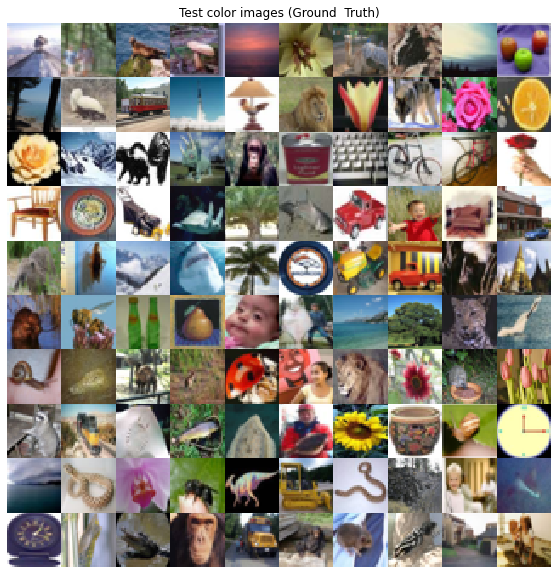

In [90]:
img_rows = rows
img_cols = cols 

imgs_t = x_test[:100]
imgs_t = imgs_t.reshape((10,10, img_rows, img_cols, channels))
imgs_t = np.vstack([np.hstack(i) for i in imgs_t])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test_color.png')
plt.show()

# Imágenes en escala de grises

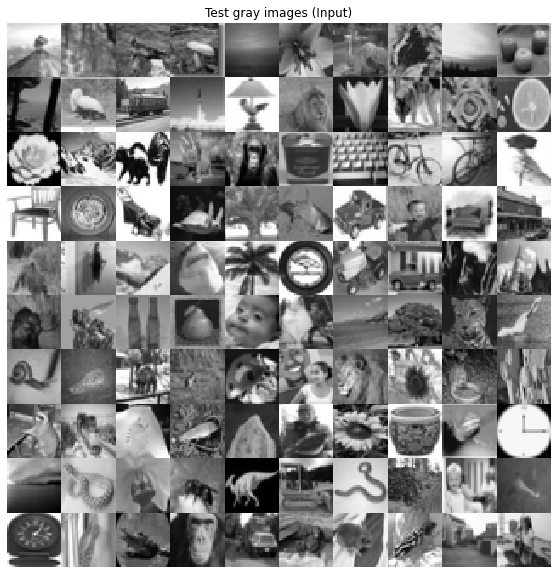

In [97]:
img_rows = rows
img_cols = cols 

imgs_g = x_test_gray[:100]
imgs_g = imgs_g.reshape((10,10, img_rows, img_cols))
imgs_g = np.vstack([np.hstack(i) for i in imgs_g])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs_g, interpolation='none', cmap='gray')
plt.savefig('./test_color.png')
plt.show()

# Primeras 100 imágenes coloreadas con la predicción 

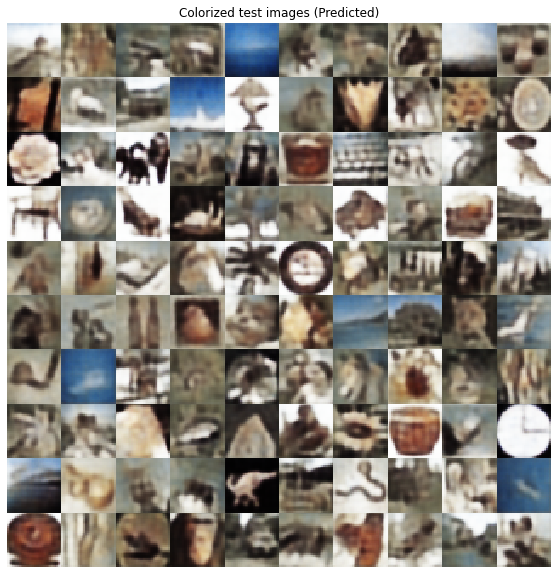

In [98]:
img_rows = rows
img_cols = cols 

imgs = x_decoded[:100]
imgs = imgs.reshape((10,10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./test_color.png')
plt.show()

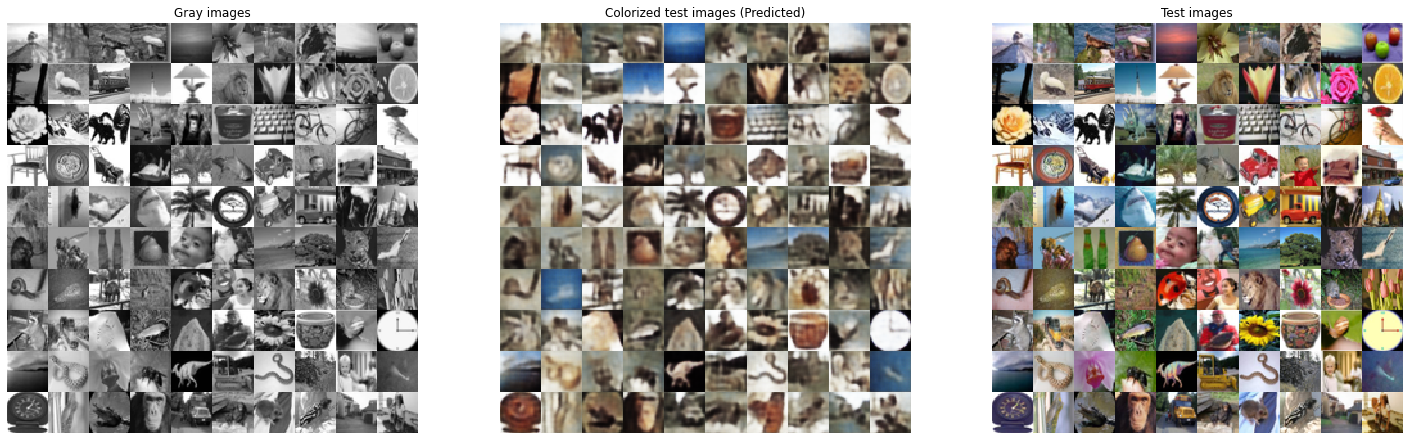

In [99]:

plt.figure(figsize=(25,25))
plt.subplot(131)
plt.axis('off')
plt.title('Gray images')
plt.imshow(imgs_g, interpolation='none',cmap='gray')
plt.savefig('./test.png')

plt.subplot(132)
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

plt.subplot(133)
plt.axis('off')
plt.title('Test images')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test.png')

plt.show()

## PREDICCIÓN CON UNA FOTO 

In [102]:
import cv2
from PIL import Image 


In [105]:
mi_foto = Image.open('./JDM.jpg')

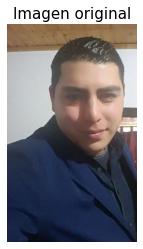

In [136]:
plt.title('Imagen original', fontsize = 15)
plt.imshow(mi_foto)
plt.axis('off')
plt.show()

# convertir la imagen a gris

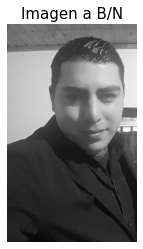

In [120]:
mi_foto_gris = Image.open('./JDM.jpg')
mi_foto_gris = mi_foto_gris.convert('L')# L significa convertir a blanco y negro 
plt.title('Imagen a B/N', fontsize = 15)
plt.imshow(mi_foto_gris, cmap='gray')
plt.axis('off')
plt.show()

# Normalizar el la imagen de entrada

In [131]:
mi_foto_gris_norm = (np.array(mi_foto_gris))/255. 

print('La forma de la imagen reducida es:', mi_foto_gris_norm.shape)
mi_foto_gris_norm = cv2.resize(mi_foto_gris_norm,(32,32)).flatten()
print('Data flatten',mi_foto_gris_norm.shape)
mi_foto_gris_norm = np.array(mi_foto_gris_norm).reshape(1,32,32,1)
print('Nueva forma de los datos:', mi_foto_gris_norm.shape)

La forma de la imagen reducida es: (507, 302)
Data flatten (1024,)
Nueva forma de los datos: (1, 32, 32, 1)


# Colorear

In [149]:
Mi_Foto_Color = autoencoder_colorizing.predict(mi_foto_gris_norm)
print('La dimensión de mi foto es de',Mi_Foto_Color.shape)

La dimensión de mi foto es de (1, 32, 32, 3)


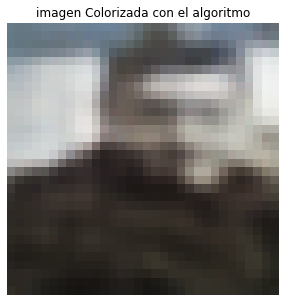

In [147]:

imgs = Mi_Foto_Color
imgs = imgs.reshape((img_rows, img_cols, channels))
plt.figure(figsize=(5,5))
plt.title('imagen Colorizada con el algoritmo')
plt.imshow(imgs)
plt.savefig('./test_color.png')
plt.axis('off')
plt.show()

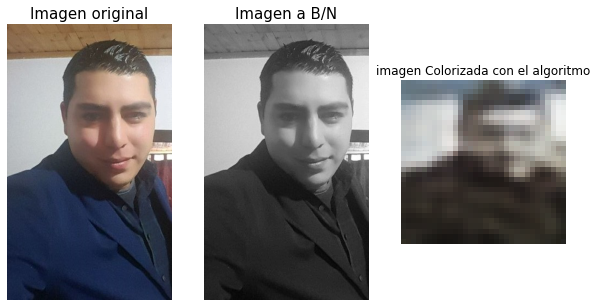

In [153]:

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.axis('off')
plt.title('Imagen original', fontsize = 15)
plt.imshow(mi_foto)
plt.axis('off')

plt.subplot(132)
plt.axis('off')
plt.title('Imagen a B/N', fontsize = 15)
plt.imshow(mi_foto_gris, cmap='gray')

plt.subplot(133)
plt.axis('off')
plt.title('imagen Colorizada con el algoritmo')
plt.imshow(imgs)

plt.show()